In [2]:
def generate_sensor_data(num_samples=10000):
    np.random.seed(42)
    time = np.arange(num_samples)
    temperature = 50 + 10*np.sin(time/100) + np.random.normal(0, 3, num_samples)
    vibration = 0.5 + 0.3*np.sin(time/50) + np.random.normal(0, 0.1, num_samples)

    # Introduce anomalies (5% of data)
    anomaly_indices = np.random.choice(num_samples, size=int(0.05*num_samples), replace=False)
    temperature[anomaly_indices] *= 1.5
    vibration[anomaly_indices] *= 2.0

    df = pd.DataFrame({'timestamp': time, 'temperature': temperature, 'vibration': vibration})
    df['anomaly'] = 0
    df.loc[anomaly_indices, 'anomaly'] = 1
    return df

sensor_df = generate_sensor_data()
sensor_df.head()

,timestamp,temperature,vibration,anomaly
0,0,51.490142,0.432151,0
1,1,49.685205,0.475450,0
2,2,52.143052,0.452259,0
3,3,54.869045,0.529031,0
4,4,49.697433,0.643692,0


In [3]:
def generate_grid_data(num_nodes=10):
    np.random.seed(42)
    nodes = [f"Substation_{i}" for i in range(num_nodes)]

    # Create random grid connections
    G = nx.gnm_random_graph(num_nodes, num_nodes*2, seed=42)

    # Add attributes
    for _, _, d in G.edges(data=True):
        d['resistance'] = np.random.uniform(0.1, 1.0)
        d['capacity'] = np.random.uniform(100, 500)

    for n in G.nodes():
        G.nodes[n]['demand'] = np.random.uniform(50, 200)
        G.nodes[n]['generation'] = np.random.uniform(0, 100)

    return G

grid = generate_grid_data()

In [4]:
def generate_smart_meter_data(num_customers=500, days=90):
    np.random.seed(42)
    date_range = pd.date_range(end=pd.Timestamp.today(), periods=days)
    data = []

    for cust_id in range(num_customers):
        base_usage = np.random.normal(30, 10)

        # Normal usage patterns
        daily_usage = [max(0, base_usage +
                          np.random.normal(0, 5) +
                          10*np.sin(i/7)) for i in range(days)]

        # Introduce theft (10% of customers)
        is_thief = (cust_id % 10 == 0)
        theft_days = np.random.choice(days, size=30, replace=False) if is_thief else []

        for day in range(days):
            usage = daily_usage[day]
            if day in theft_days:
                # Steal 30-70% of power
                reported_usage = usage * np.random.uniform(0.3, 0.7)
            else:
                reported_usage = usage

            data.append([
                f"CUST_{cust_id}",
                date_range[day],
                usage,
                reported_usage,
                is_thief
            ])

    return pd.DataFrame(data, columns=['customer_id', 'date', 'actual_usage', 'reported_usage', 'theft'])

meter_df = generate_smart_meter_data()

In [5]:
def generate_smart_meter_data(num_customers=500, days=90):
    np.random.seed(42)
    date_range = pd.date_range(end=pd.Timestamp.today(), periods=days)
    data = []

    for cust_id in range(num_customers):
        base_usage = np.random.normal(30, 10)

        # Normal usage patterns
        daily_usage = [max(0, base_usage +
                          np.random.normal(0, 5) +
                          10*np.sin(i/7)) for i in range(days)]

        # Introduce theft (10% of customers)
        is_thief = (cust_id % 10 == 0)
        theft_days = np.random.choice(days, size=30, replace=False) if is_thief else []

        for day in range(days):
            usage = daily_usage[day]
            if day in theft_days:
                # Steal 30-70% of power
                reported_usage = usage * np.random.uniform(0.3, 0.7)
            else:
                reported_usage = usage

            data.append([
                f"CUST_{cust_id}",
                date_range[day],
                usage,
                reported_usage,
                is_thief
            ])

    return pd.DataFrame(data, columns=['customer_id', 'date', 'actual_usage', 'reported_usage', 'theft'])

meter_df = generate_smart_meter_data()

In [6]:
# Prepare data
X = sensor_df[['temperature', 'vibration']]
y = sensor_df['anomaly']

# Train Isolation Forest
model_anomaly = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model_anomaly.fit(X)
sensor_df['predicted_anomaly'] = model_anomaly.predict(X)

# Convert predictions (1=normal, -1=anomaly)
sensor_df['predicted_anomaly'] = sensor_df['predicted_anomaly'].map({1: 0, -1: 1})

# Evaluate
print(classification_report(y, sensor_df['predicted_anomaly']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9500
           1       0.78      0.78      0.78       500

    accuracy                           0.98     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.98      0.98      0.98     10000



In [7]:
import cvxpy as cp
import networkx as nx
import numpy as np

def optimize_power_flow(graph: nx.Graph):
    try:
        # Step 1: Setup
        edges = list(graph.edges(data=True))
        nodes = list(graph.nodes(data=True))
        node_indices = list(graph.nodes())

        # Mapping edges to variables
        edge_indices = [(u, v) for u, v, _ in edges]
        P = cp.Variable(len(edges))  # Power flow on each edge

        # Step 2: Objective function (Minimize total power loss)
        resistances = [attr.get('resistance', 1.0) for _, _, attr in edges]
        objective = cp.Minimize(cp.sum(cp.multiply(cp.square(P), resistances)))

        # Step 3: Constraints
        constraints = []

        # Capacity constraints
        capacities = [attr.get('capacity', 1e3) for _, _, attr in edges]
        for i in range(len(edges)):
            constraints.append(P[i] <= capacities[i])
            constraints.append(P[i] >= -capacities[i])

        # Power balance constraints for each node
        for node in node_indices:
            in_flow = []
            out_flow = []
            for i, (u, v) in enumerate(edge_indices):
                if v == node:
                    in_flow.append(P[i])
                elif u == node:
                    out_flow.append(P[i])

            net_flow = cp.sum(in_flow) - cp.sum(out_flow)
            generation = graph.nodes[node].get('generation', 0.0)
            demand = graph.nodes[node].get('demand', 0.0)
            constraints.append(net_flow == generation - demand)

        # Step 4: Solve the problem
        problem = cp.Problem(objective, constraints)
        try:
            problem.solve(solver=cp.ECOS)
        except cp.error.SolverError:
            problem.solve(solver=cp.SCS)

        # Step 5: Handle infeasibility or errors
        if problem.status not in ["optimal", "optimal_inaccurate"]:
            raise ValueError("Optimization failed with status: " + str(problem.status))

        # Step 6: Return power flow values
        return P.value

    except Exception as e:
        print("Error during optimization:", str(e))
        return None


In [8]:
import networkx as nx

# Create a small test graph
G = nx.Graph()
G.add_node(0, generation=100.0, demand=0.0)
G.add_node(1, generation=0.0, demand=60.0)
G.add_node(2, generation=0.0, demand=40.0)
G.add_edge(0, 1, resistance=0.1, capacity=100)
G.add_edge(0, 2, resistance=0.1, capacity=100)
G.add_edge(1, 2, resistance=0.2, capacity=50)

flows = optimize_power_flow(G)
print("Optimized power flows:", flows)


Optimized power flows: [-55.000001   -45.00000087   5.00000012]


In [9]:
# Prepare time-series data
def prepare_sequences(df, seq_length=7):
    sequences = []
    labels = []

    for cust_id, group in df.groupby('customer_id'):
        theft_days = group[group['theft']].index
        for i in range(seq_length, len(group)):
            seq = group['reported_usage'].values[i-seq_length:i]
            label = 1 if i in theft_days else 0
            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)

X, y = prepare_sequences(meter_df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model_theft = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model_theft.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_theft.fit(
    X_train[..., np.newaxis],
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Evaluate
test_loss, test_acc = model_theft.evaluate(X_test[..., np.newaxis], y_test)
print(f"Test Accuracy: {test_acc:.4f}")

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9639 - loss: 0.0988 - val_accuracy: 0.9988 - val_loss: 0.0097
Epoch 2/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9981 - loss: 0.0141 - val_accuracy: 0.9988 - val_loss: 0.0096
Epoch 3/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9979 - loss: 0.0153 - val_accuracy: 0.9988 - val_loss: 0.0095
Epoch 4/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 1754s 4s/step - accuracy: 0.9980 - loss: 0.0144 - val_accuracy: 0.9988 - val_loss: 0.0096
Epoch 5/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9980 - loss: 0.0143 - val_accuracy: 0.9988 - val_loss: 0.0099
Epoch 6/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9984 - loss: 0.0121 - val_accuracy: 0.9988 - val_loss: 0.0099
Epoch 7/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9975 - loss: 0.0174 - val_accuracy: 0.9988 - val_loss: 0.0094
Epoch 8/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9982 - loss: 0.0133 - val_ac

Error during optimization: Optimization failed with status: infeasible


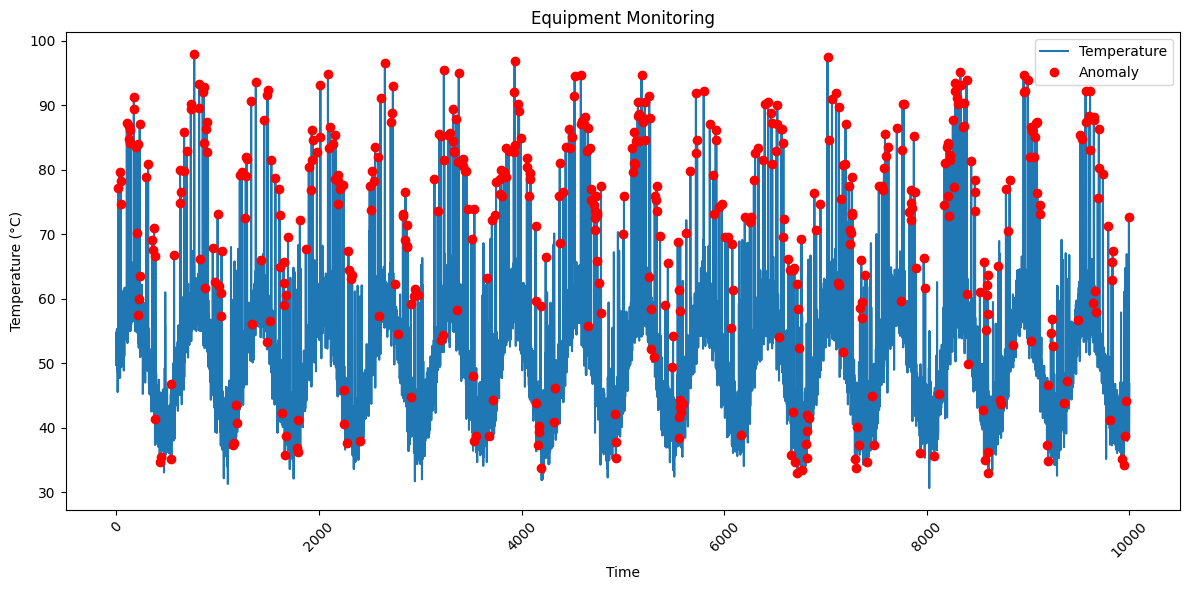

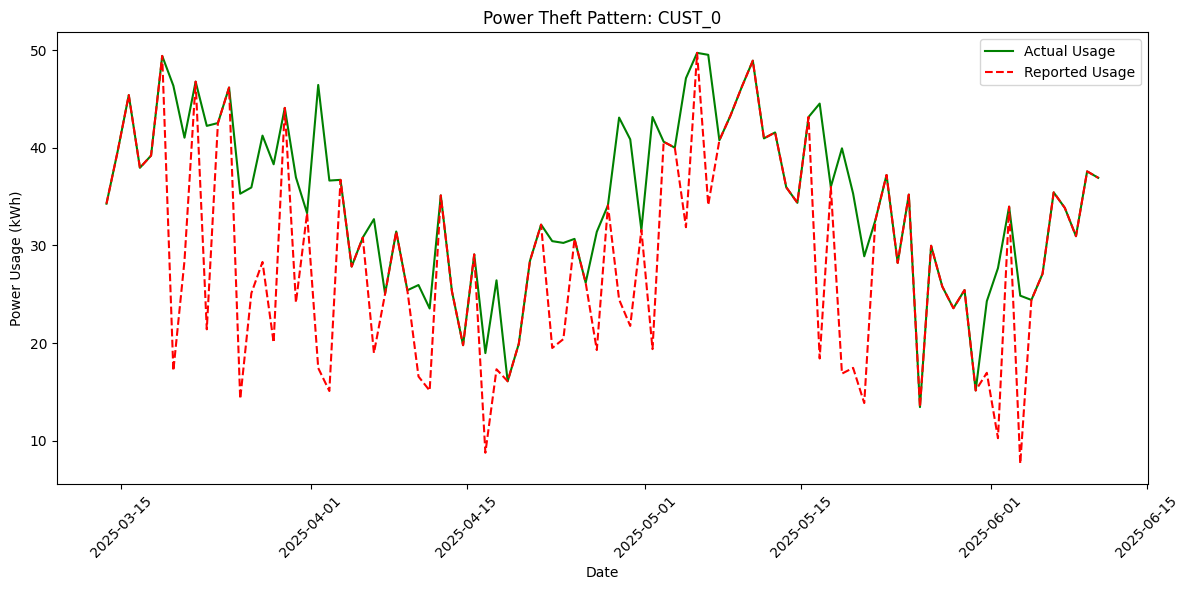

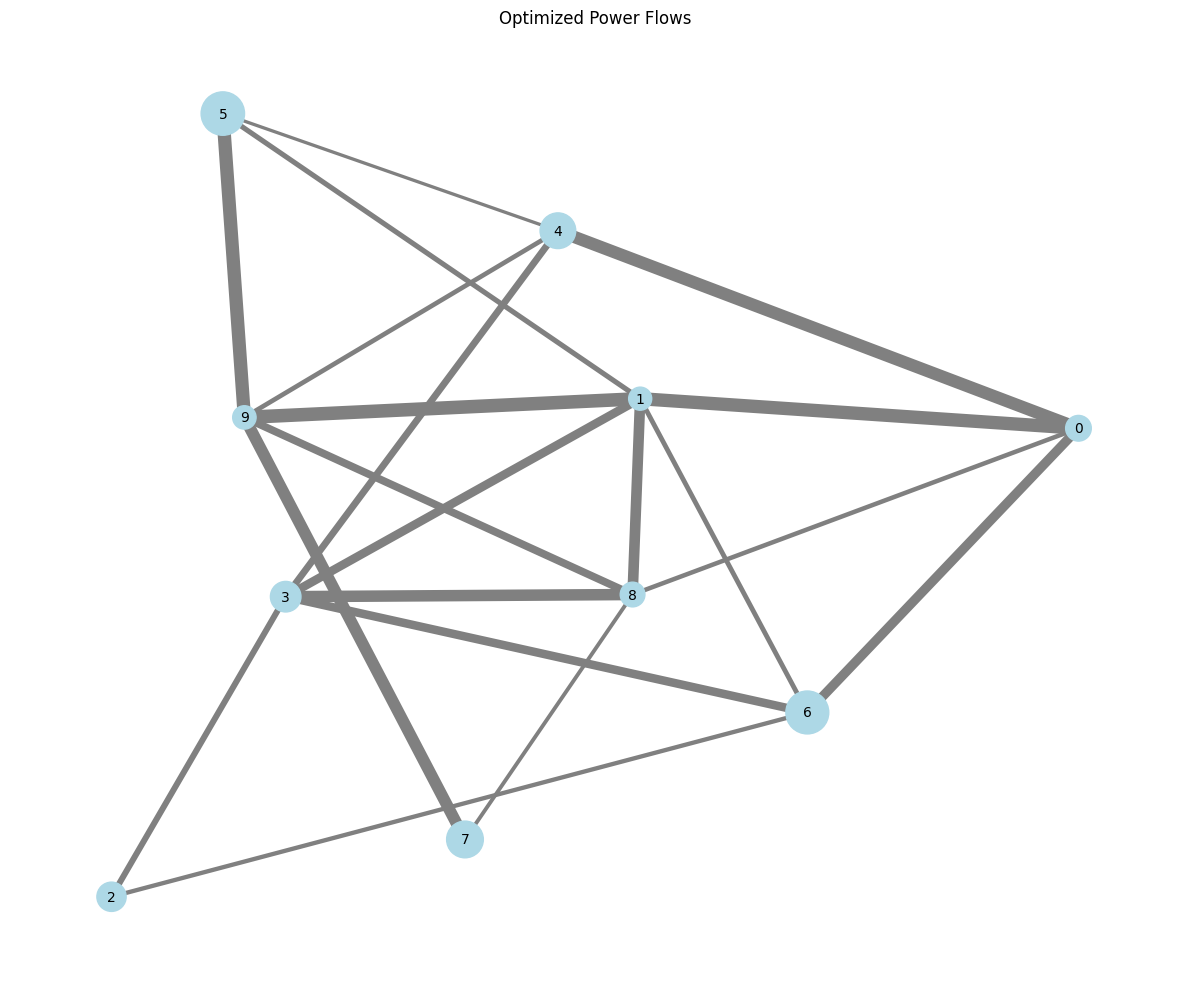

In [11]:
# STEP 0: Run optimization before visualization
optimized_flows = optimize_power_flow(grid)

# STEP 1: Equipment monitoring dashboard
plt.figure(figsize=(12, 6))
plt.plot(sensor_df['timestamp'], sensor_df['temperature'], label='Temperature')
plt.plot(sensor_df[sensor_df['predicted_anomaly'] == 1]['timestamp'],
         sensor_df[sensor_df['predicted_anomaly'] == 1]['temperature'],
         'ro', label='Anomaly')
plt.title('Equipment Monitoring')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# STEP 2: Power theft visualization
plt.figure(figsize=(12, 6))
if not meter_df[meter_df['theft']].empty:
    sample_thief = meter_df[meter_df['theft']].iloc[0]['customer_id']
    sample_data = meter_df[meter_df['customer_id'] == sample_thief]
    plt.plot(sample_data['date'], sample_data['actual_usage'], 'g-', label='Actual Usage')
    plt.plot(sample_data['date'], sample_data['reported_usage'], 'r--', label='Reported Usage')
    plt.title(f'Power Theft Pattern: {sample_thief}')
    plt.xlabel('Date')
    plt.ylabel('Power Usage (kWh)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
else:
    print("No theft data found. Skipping theft visualization.")

# STEP 3: Grid optimization results
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(grid, seed=42)

# Draw nodes sized by demand (minimum size = 1)
node_sizes = [max(grid.nodes[n].get('demand', 1.0), 1) * 5 for n in grid.nodes]
nx.draw_networkx_nodes(grid, pos, node_size=node_sizes, node_color='lightblue')

# Draw edges sized by capacity
edge_widths = [grid[u][v].get('capacity', 1.0) / 50 for u, v in grid.edges]
nx.draw_networkx_edges(grid, pos, width=edge_widths, edge_color='gray')

# Draw node labels
nx.draw_networkx_labels(grid, pos, font_size=10)

# Add flow labels if optimization succeeded
if optimized_flows is not None:
    edge_labels = {}
    for i, (u, v) in enumerate(grid.edges):
        if i < len(optimized_flows):
            edge_labels[(u, v)] = f"{optimized_flows[i]:.1f} MW"
        else:
            edge_labels[(u, v)] = "N/A"
    nx.draw_networkx_edge_labels(grid, pos, edge_labels=edge_labels, font_size=9)

plt.title('Optimized Power Flows')
plt.axis('off')
plt.tight_layout()
plt.show()


In [14]:
# save_all_artifacts.py

import os
import joblib
import numpy as np
import networkx as nx
from tensorflow.keras.models import load_model

# Unified folder
SAVE_DIR = "smart_grid_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. Save Isolation Forest model
def save_isolation_forest(model):
    path = os.path.join(SAVE_DIR, "isolation_forest_model.pkl")
    joblib.dump(model, path)
    print(f"[✓] Isolation Forest saved to {path}")

# 2. Save LSTM model
def save_lstm_model(model):
    path = os.path.join(SAVE_DIR, "lstm_theft_model.h5")
    model.save(path)
    print(f"[✓] LSTM model saved to {path}")

# 3. Save scaler (if used)
def save_scaler(scaler):
    path = os.path.join(SAVE_DIR, "scaler.pkl")
    joblib.dump(scaler, path)
    print(f"[✓] Scaler saved to {path}")

# 4. Save optimized power flow values
def save_power_flow(power_values):
    path = os.path.join(SAVE_DIR, "optimized_power_flow.npy")
    np.save(path, power_values)
    print(f"[✓] Power flow saved to {path}")

# 5. Save graph
def save_graph(graph):
    path = os.path.join(SAVE_DIR, "grid_network.gml")
    nx.write_gml(graph, path)
    print(f"[✓] Graph saved to {path}")

# Main function to save everything
def save_everything(model_anomaly, model_theft, power_values, graph, scaler=None):
    save_isolation_forest(model_anomaly)
    save_lstm_model(model_theft)
    if scaler is not None:
        save_scaler(scaler)
    save_power_flow(power_values)
    save_graph(graph)
    print("\n✅ All models and data saved in one folder: smart_grid_artifacts\n")


In [15]:
from save_all_artifacts import save_everything

save_everything(model_anomaly, model_theft, P.value, graph, scaler)


ModuleNotFoundError: No module named 'save_all_artifacts'